# Topographic diffusion of lunar impact craters

### Let's try to recreate these results from Fasset and Thomson 2014

<p align="center">
    <img src="/Users/phillipsm/Documents/Teaching/AI_in_PlanetaryXXX/Code/02_Curve_Fitting/notebooks/pinns/src/crater_diffusion/files/fasset_thompson_2014_diffusion_profiles.jpg" alt="Fasset and Thomson diffusion 2014">
</p>

## Initial crater topography

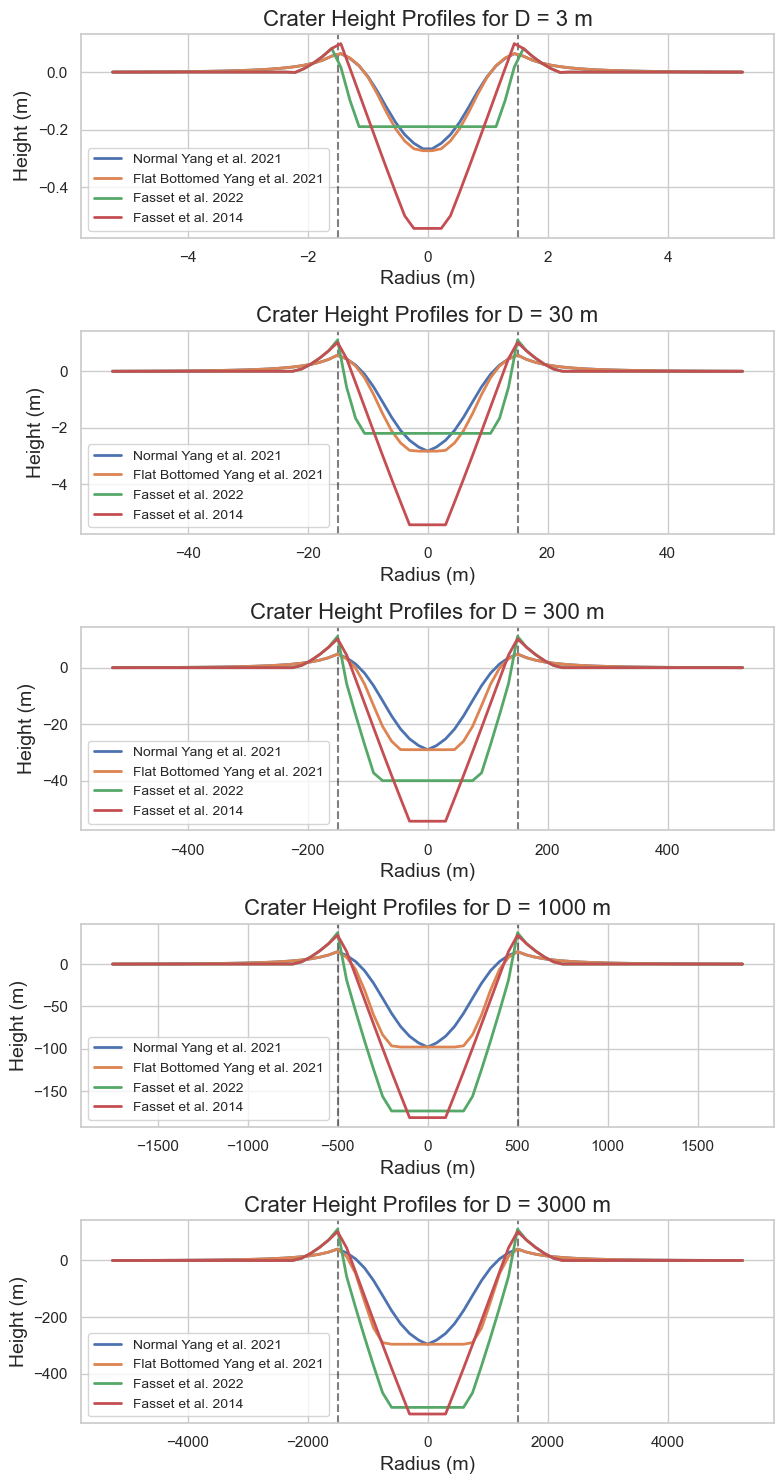

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from crater_diffusion_utils import h_of_r_normal_yang, h_of_r_flat_bottomed_yang, h_of_r_fasset2014, h_of_r_fasset2022
import seaborn as sns

# crater diameter in m
D_list = [3, 30, 300, 1000, 3000]
fig, axs = plt.subplots(len(D_list), 1, figsize=(8, 15))

for i, D in enumerate(D_list):
    radius = D / 2

    dx = 0.05 * D # 5% crater diameter step size
    r_values = np.linspace(-3.5 * radius, 3.5 * radius, int(3.5 * D / dx) + 1)
    normalized_r_values = r_values / radius

    # compute the height of the crater for each r value
    # Set the style for seaborn
    sns.set_theme(style="whitegrid")

    # Plot vertical dash lines at the rim of the crater
    axs[i].axvline(x=1 * radius, color='black', linestyle='--', alpha=0.5)
    axs[i].axvline(x=-1 * radius, color='black', linestyle='--', alpha=0.5)

    # Yang normal crater function
    height_values_normalized = h_of_r_normal_yang(normalized_r_values, D)
    height_values_normalized -= height_values_normalized[0]
    height_values = height_values_normalized * D
    axs[i].plot(r_values, height_values, label="Normal Yang et al. 2021", linewidth=2)

    # Yang flat bottomed crater function
    height_values_normalized = h_of_r_flat_bottomed_yang(normalized_r_values, D)
    height_values_normalized -= height_values_normalized[0]
    height_values = height_values_normalized * D
    axs[i].plot(r_values, height_values, label="Flat Bottomed Yang et al. 2021", linewidth=2)

    # Fasset 2022 crater function
    height_values_normalized = h_of_r_fasset2022(r_values, D)
    height_values = height_values_normalized * D
    axs[i].plot(r_values, height_values, label="Fasset et al. 2022", linewidth=2)

    # Fasset 2014 crater function
    height_values_normalized = h_of_r_fasset2014(r_values, D)
    height_values = height_values_normalized * D
    axs[i].plot(r_values, height_values, label="Fasset et al. 2014", linewidth=2)

    # Set labels and title
    axs[i].set_xlabel("Radius (m)", fontsize=14)
    axs[i].set_ylabel("Height (m)", fontsize=14)
    axs[i].set_title(f"Crater Height Profiles for D = {D} m", fontsize=16)

    # Add legend
    axs[i].legend(loc='best', fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()


# Topographic Diffusion in 1 Spatial Dimension

<div style="font-size: 1.25em;">

Let $h(x,t)$ represent the topographic height as a function of space $(x)$ and time $(t)$.  
The diffusion equation in one dimension is:

$$\frac{\partial h}{\partial t} = \kappa \frac{\partial^2 h}{\partial x^2}$$

where $\kappa$ is the diffusivity coefficient measured in $\text{m}^2/\text{Myr}$

</div>

# implicit solution in 1 dimension

dt = 5
max dt = 9.090909090909092


  0%|          | 0/601 [00:00<?, ?it/s]

100%|██████████| 601/601 [00:00<00:00, 14187.57it/s]


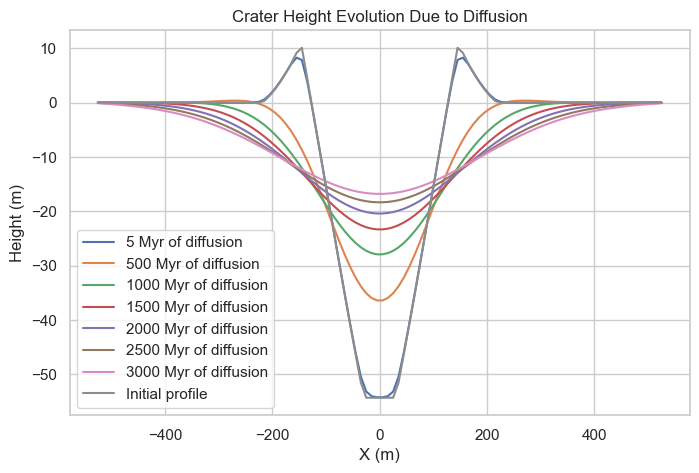

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from crater_diffusion_utils import h_of_r_fasset2014

# Crater parameters and initial topography setup
D = 300 # crater diameter in m
radius = D / 2

# Spatial Parameters
r_max =  3.5 * radius # half grid extent in meters
dx_m = 10 # Spatial step size in meters 

# Time Parameters
tot_time = 3000 # Total time in million years 
dt_m = 5 # Time step in million years
t_steps = int(tot_time / dt_m) + 1 # Number of time steps
t = np.linspace(0, tot_time, t_steps) # Time steps in million years

kappa = 5.5  # Diffusion coefficient m^2 / Myr

# Grid
x = np.linspace(-r_max, r_max, int(2*r_max / dx_m) + 1) # Grid in meters
normalized_x = x / radius # Normalized r for input to h_of_r

# Stability condition for explicit scheme: dt <= (dx^2) / (2 * kappa)
print(f'dt = {dt_m}')
print(f'max dt = {(dx_m**2) / (2 * kappa)}')
if dt_m > (dx_m**2) / (2 * kappa):
    dt_ = (dx_m**2) / (2 * kappa)
    raise ValueError(f"Time step {dt_m} is too large for stability. \nReduce dt_m to {dt_} or increase dx_m.")

h_new = np.zeros_like(x)

h0 = h_of_r_fasset2014(x, D)  # Initialize h
h0 -= h0[0]  # Normalize the initial profile
h = h0.copy()
h_time = []
kt_values = []

# Time evolution
# Precompute constants
alpha_ = kappa * dt_m / dx_m**2  # Dimensionless parameter for diffusion

# Construct the tridiagonal matrix AA
n = len(x)
diagonals = [
    (1 + 2 * alpha_) * np.ones(n),      # Main diagonal
    -alpha_ * np.ones(n - 1),           # Upper diagonal
    -alpha_ * np.ones(n - 1)            # Lower diagonal
]

AA = diags(diagonals, [0, 1, -1], format='csr')  # Sparse tridiagonal matrix

# Time evolution
for t_ in tqdm(t):
    # Solve the linear system A * h_new = h
    h_new = spsolve(AA, h)
    kt_values.append(kappa * t_ * dt_m) # in m^2
    h[:] = h_new  # Update for the next time step
    h_time.append(h.copy())

h_time = np.array(h_time).T

# Plot results
plt.figure(figsize=(8, 5))
plot_steps = np.linspace(1, t_steps-1, 7, dtype=int)
for ti in plot_steps:
    plt.plot(x, D * h_time[:,ti], label=f"{np.round(dt_m*ti,2)} Myr of diffusion")
plt.plot(x, D * h0, label="Initial profile")
plt.legend()
plt.xlabel("X (m)")
plt.ylabel("Height (m)")
plt.title("Crater Height Evolution Due to Diffusion")
plt.show()

<div style="font-size: 1.5em;">
This looks ~okay~ but we're missing something by only modeling 1 spatial dimension. Let's scale up to 2-D
</div>

# 2-D implementation

<div style="font-size: 1.5em;">

Let $h(x, y, t)$ represent the topographic height as a function of space $(x, y)$ and time $(t)$.  
The diffusion equation becomes:

$$\frac{\partial h}{\partial t} = \kappa \nabla^2 h$$
or, alternatively:
$$\frac{\partial h}{\partial t} = \kappa (\frac{\partial^2 h}{\partial x^2} + \frac{\partial^2 h}{\partial y^2}) $$

</div>

## Explicit solution

CFL number: 0.11


100%|██████████| 3001/3001 [00:12<00:00, 245.76it/s]


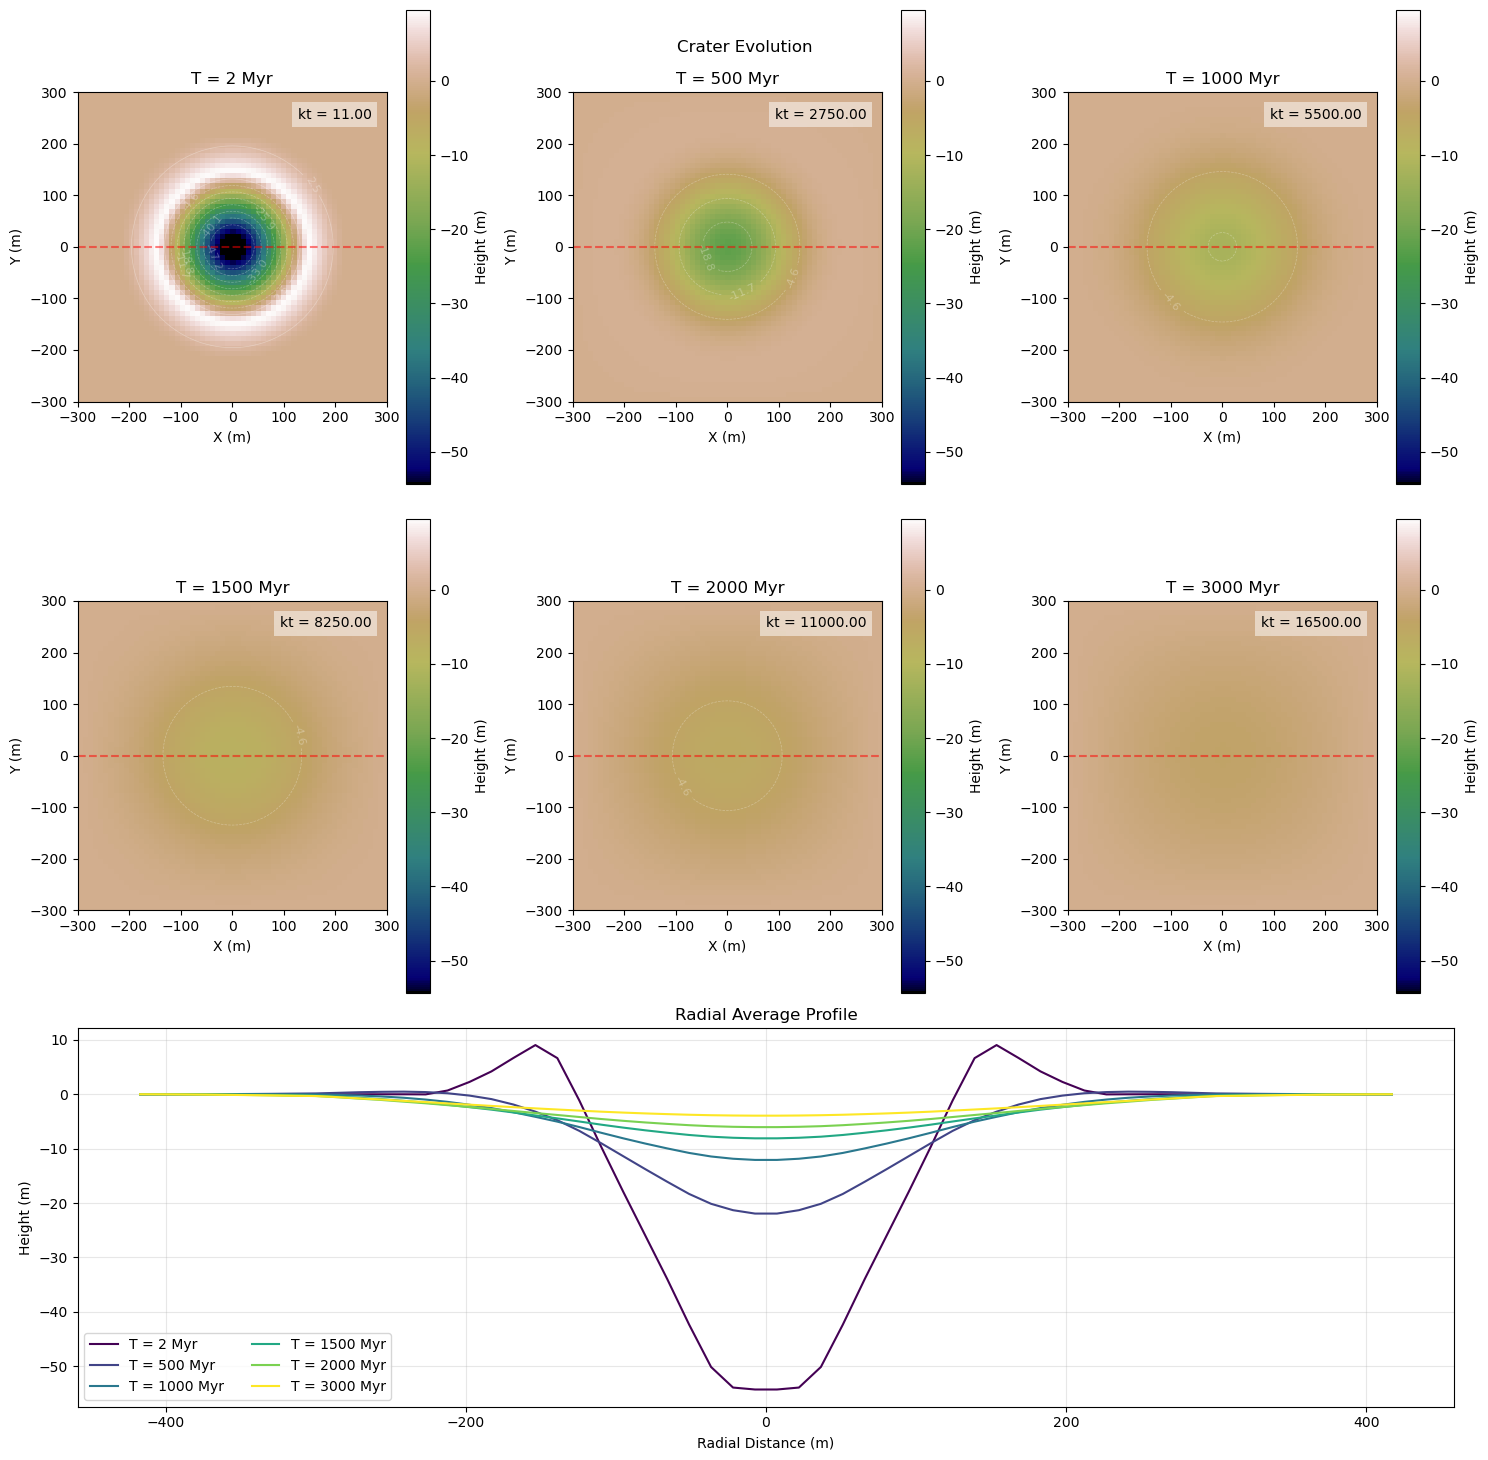

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from crater_diffusion_utils import h_of_r_fasset2014, plot_crater_evolution

# ============= Crater Parameters =============
# These parameters define the crater shape based on empirical relationships
D = 300.0  # Crater diameter in meters
radius = D / 2

# ============= Numerical Parameters =============
dx = 10  # Spatial step in x direction (meters)
dy = dx  # Spatial step in y direction (meters)
dt = 1  # Time step (million years)
lx, ly = 2*D, 2*D  # Domain size in x and y (meters)
total_time = 3000.0  # Total simulation time (million years)
kappa = 5.5  # Diffusion coefficient (m²/Myr)

# ============= Initialize Grid =============
# Create spatial grid
nx, ny = int(lx / dx) + 1, int(ly / dy) + 1
x = np.linspace(-lx / 2, lx / 2, nx)
y = np.linspace(-ly / 2, ly / 2, ny)
x_grid, y_grid = np.meshgrid(x, y) # in meters
# Calculate normalized radial distances
r_grid = np.sqrt(x_grid**2 + y_grid**2)
# Generate initial crater topography
initial_h = h_of_r_fasset2014(r_grid, D) * D # in meters


# ============= Stability Check =============
# Check Courant-Friedrichs-Lewy (CFL) condition for numerical stability
cfl = kappa * dt * (1 / dx**2 + 1 / dy**2)
print(f"CFL number: {cfl}")
if cfl > 0.5:
    print(f'kappa = {kappa}')
    print(f'spatial step = {(1 / dx**2 + 1 / dy**2)}')
    dt = int(np.floor(0.5 / (kappa * (1 / dx**2 + 1 / dy**2))))
    print(f'new dt is: {dt}')

# ============= Time Integration =============
# Initialize arrays for simulation
h = initial_h.copy()
num_steps = int(total_time / dt) + 1
h_over_time = np.zeros((num_steps, nx, ny))  # Store full time evolution

# Main time integration loop
for n in tqdm(range(num_steps)):
    h_new = h.copy()
    # Iterate over interior points
    for i in range(1, nx - 1):
        for j in range(1, ny - 1):
            # Explicit finite difference scheme for 2D diffusion equation
            # ∂h/∂t = κ(∂²h/∂x² + ∂²h/∂y²)
            h_new[i, j] = (
                h[i, j]  # Current value
                + kappa * dt * (
                    # x-direction second derivative
                    (h[i + 1, j] - 2 * h[i, j] + h[i - 1, j]) / dx**2
                    # y-direction second derivative
                    + (h[i, j + 1] - 2 * h[i, j] + h[i, j - 1]) / dy**2
                )
            )
    
    # Apply zero-value boundary conditions
    h_new[0, :] = 0   # Left boundary
    h_new[-1, :] = 0  # Right boundary
    h_new[:, 0] = 0   # Bottom boundary
    h_new[:, -1] = 0  # Top boundary
    
    h = h_new.copy()
    h_over_time[n] = h  # Store current state


# ============= Visualization =============
plot_times = [2, num_steps//6, num_steps//3, num_steps//2, 2*num_steps//3, num_steps-1]
fig_ = plot_crater_evolution(h_over_time, x, y, dt, kappa, plot_times)


# Implicit solution

100%|██████████| 18/18 [00:02<00:00,  7.12it/s]
/var/folders/fz/2g6_hdjd4yndg54gmwq1402c0000gn/T/ipykernel_60157/2536740195.py:78: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


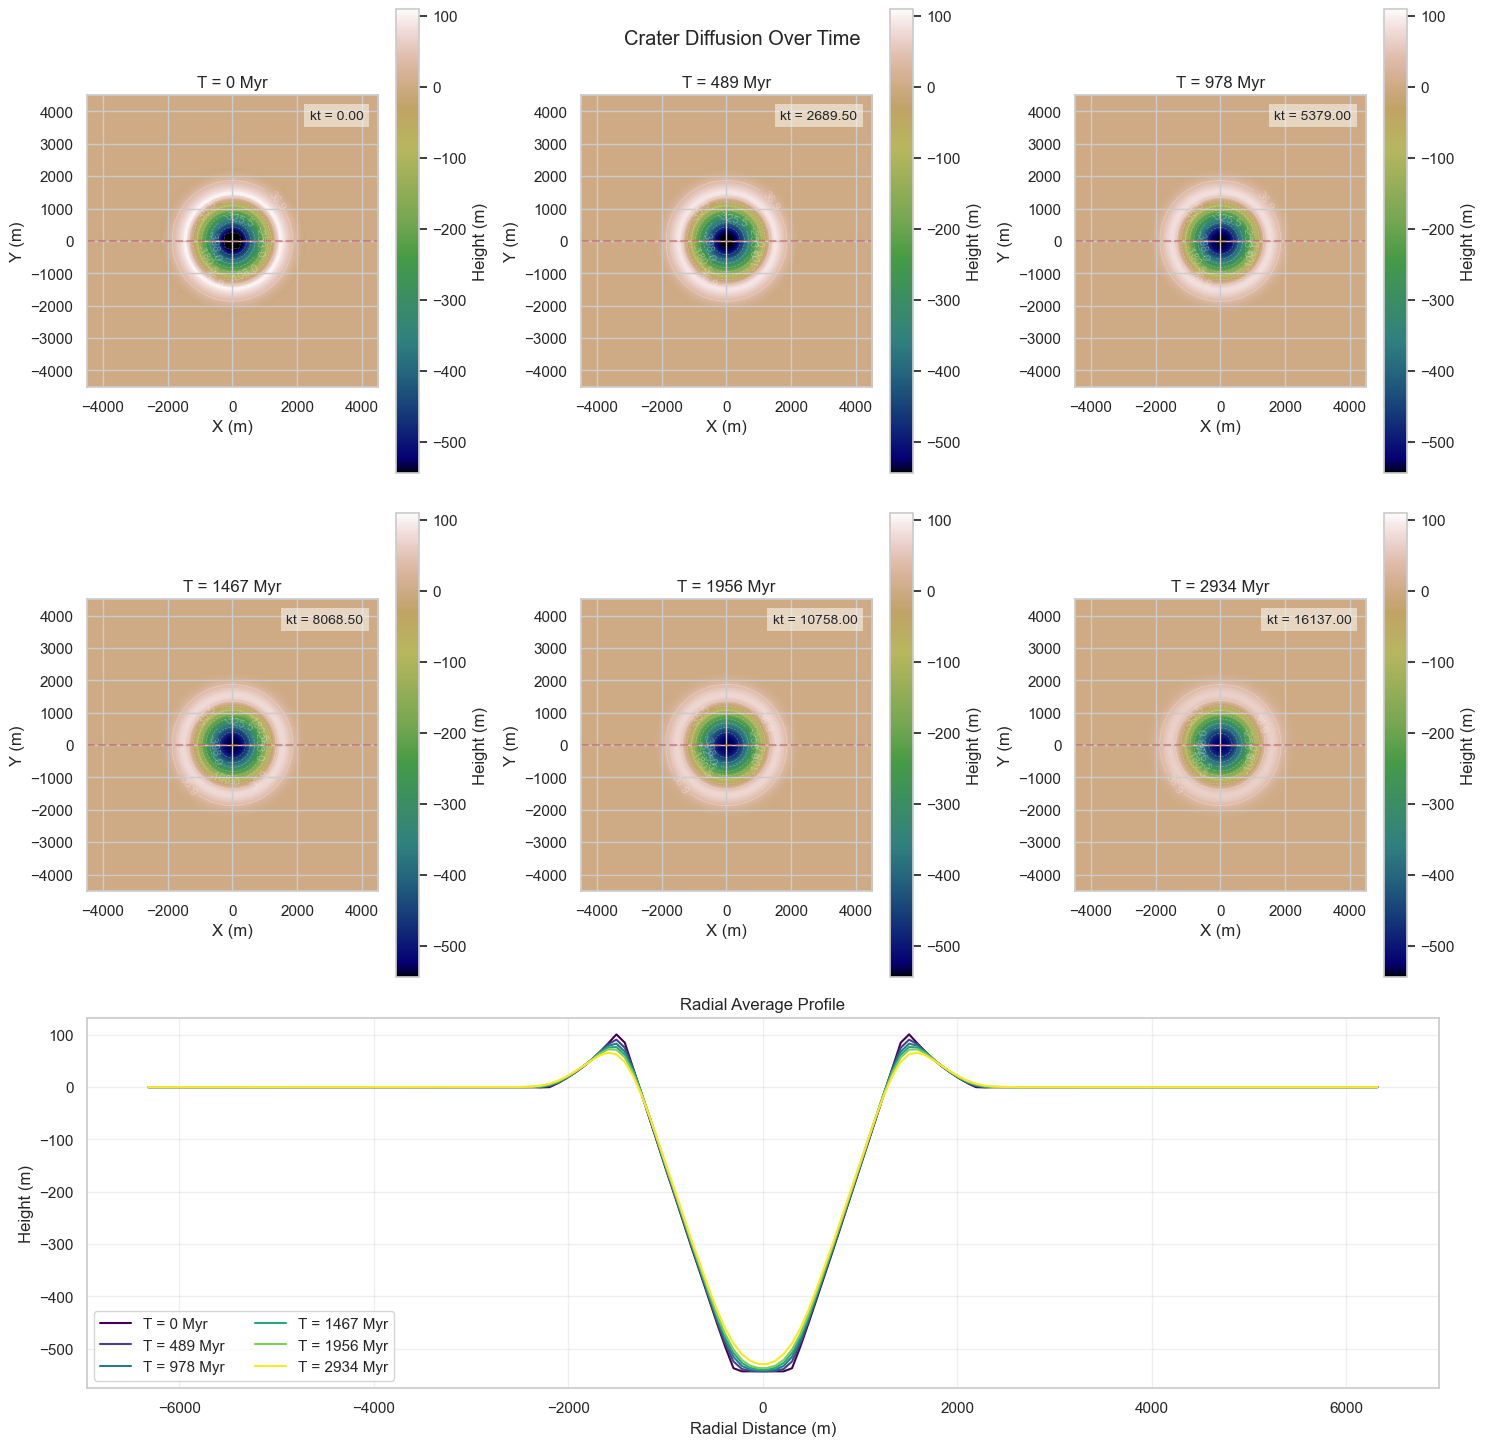

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.sparse import diags, kron, eye
from scipy.sparse.linalg import spsolve
from crater_diffusion_utils import h_of_r_fasset2014, plot_crater_evolution

# Crater parameters and initial topography setup
D = 3000  # crater diameter in m
radius = D / 2

# Spatial Parameters
r_max = 1.5*D  # half grid extent in meters
if D > 2500:
    dx_m = 60  # Spatial step size in meters
elif (D <= 2500) and (D > 100):
    dx_m = 20  # Spatial step size in meters
elif D <= 100:
    dx_m = 5  # Spatial step size in meters

kappa = 5.5  # Diffusion coefficient m^2 / Myr

# Time Parameters
max_dt = (dx_m**2) / (4 * kappa)
tot_time = 3000  # Total time in million years
dt_m = int(np.floor(max_dt)) if max_dt > 1 else max_dt  # Time step in million years, calculated based on stability condition
t_steps = int(tot_time / dt_m) + 1  # Number of time steps
t = np.linspace(0, tot_time, t_steps)  # Time steps in million years

# 2D Grid
x = np.linspace(-r_max, r_max, int(2*r_max / dx_m) + 1)  # Grid in meters
y = x.copy()  # Make a square grid
X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2) # Radial distance from the center

# Initialize height array
h0 = h_of_r_fasset2014(R, D) * D # Initialize h (normalized units)
h = h0.copy()

# Create sparse matrix for 2D diffusion
n = len(x)
alpha_ = kappa * dt_m / dx_m**2  # alpha parameter for diffusion

# Create 1D operators
eye_n = eye(n, format='csr')
D1 = diags([1, -2, 1], [-1, 0, 1], shape=(n, n), format='csr')

# Create 2D operator using Kronecker products
A2D = kron(eye_n, D1) + kron(D1, eye_n)
I2D = eye(n*n, format='csr')
AA = I2D - alpha_ * A2D

# Initialize arrays for storing results
h_time = [h0.copy()]
kt_values = []

# Time evolution
for t_ in tqdm(t[1:]):
    # Reshape 2D grid to 1D for solving
    h_flat = h.flatten()
    
    # Solve the linear system
    h_new_flat = spsolve(AA, h_flat)
    
    # Reshape back to 2D
    h = h_new_flat.reshape((n, n))
    
    kt_values.append(kappa * t_ * dt_m)  # in m^2
    h_time.append(h.copy())

# Convert to numpy array for easier slicing
h_time = np.array(h_time)

# Plot results with multiple time steps, t_steps//6
plot_times = [0, t_steps//6, t_steps//3, t_steps//2, 2*t_steps//3, t_steps-1]
# plot_times = [0, 5, 10, 60, 80, 100]
fig = plot_crater_evolution(h_time, x, y, dt_m, kappa, plot_times, "Crater Diffusion Over Time")
fig.show()

# save h_time for later use
np.savez(f"fasset2014_2D_htimes_{int(D)}m_{np.round(dt_m, 4)}.npz", h_time=h_time, x=x, y=y, dt=dt_m)

## Plot saved values

/var/folders/fz/2g6_hdjd4yndg54gmwq1402c0000gn/T/ipykernel_83190/2756179580.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


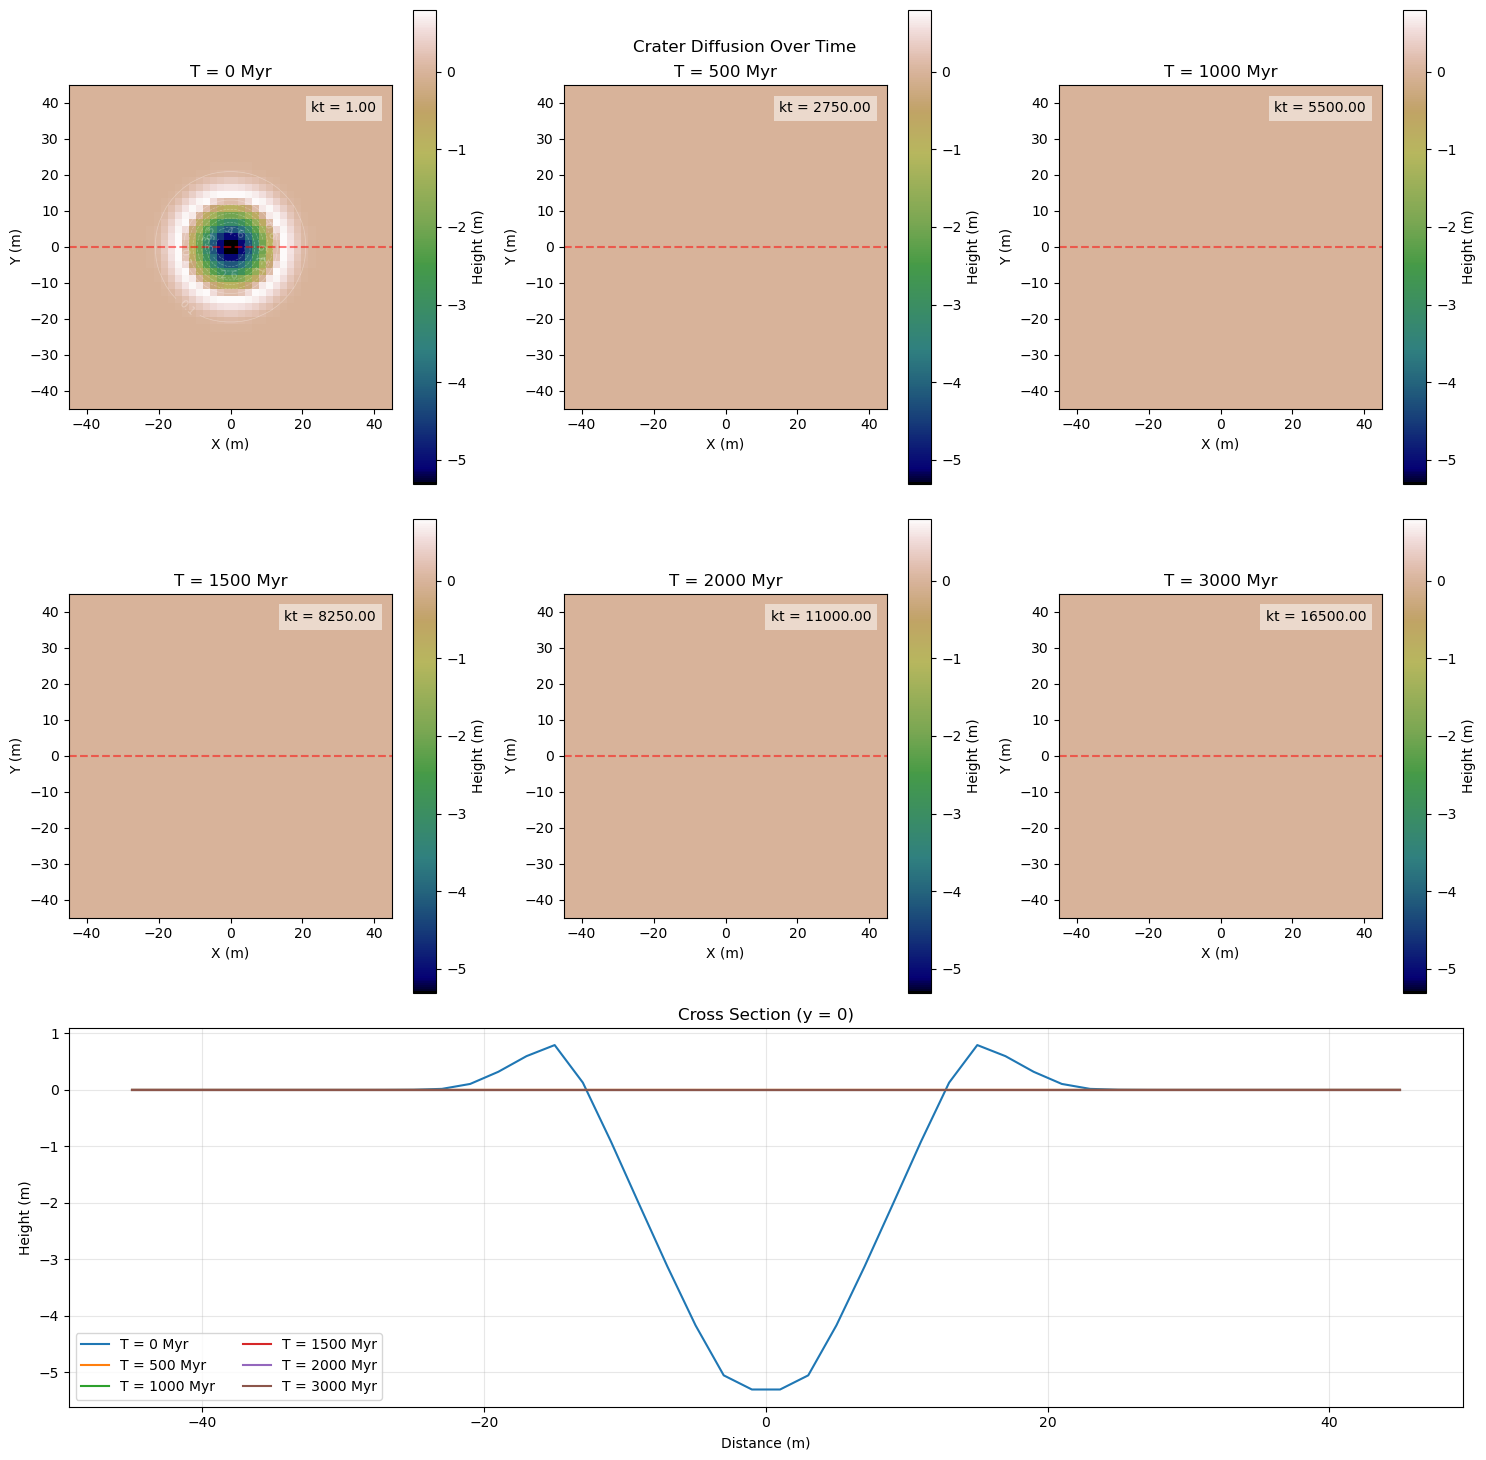

In [36]:
file_30m = 'fasset2014_2D_htimes_30m_0.18181818181818182.npz'
file_75m = 'fasset2014_2D_htimes_75m_0.18181818181818182.npz'
h_time_input = np.load(file_30m)
h_time = h_time_input['h_time']
x = h_time_input['x']
y = h_time_input['y']
t_max = 3000
T = np.linspace(0, t_max, h_time.shape[0])
dt_m = h_time_input['dt']

# Plot results with multiple time steps, t_steps//6
plot_times = [1, t_steps//6, t_steps//3, t_steps//2, 2*t_steps//3, t_steps-1]
fig = plot_crater_evolution(h_time, x, y, dt_m, kappa, plot_times, "Crater Diffusion Over Time")
fig.show()

# 2-D Physics Informed Neural Network

  0%|          | 0/50000 [00:00<?, ?it/s]

Early stopping at epoch 29951


/var/folders/fz/2g6_hdjd4yndg54gmwq1402c0000gn/T/ipykernel_60157/3872500802.py:46: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


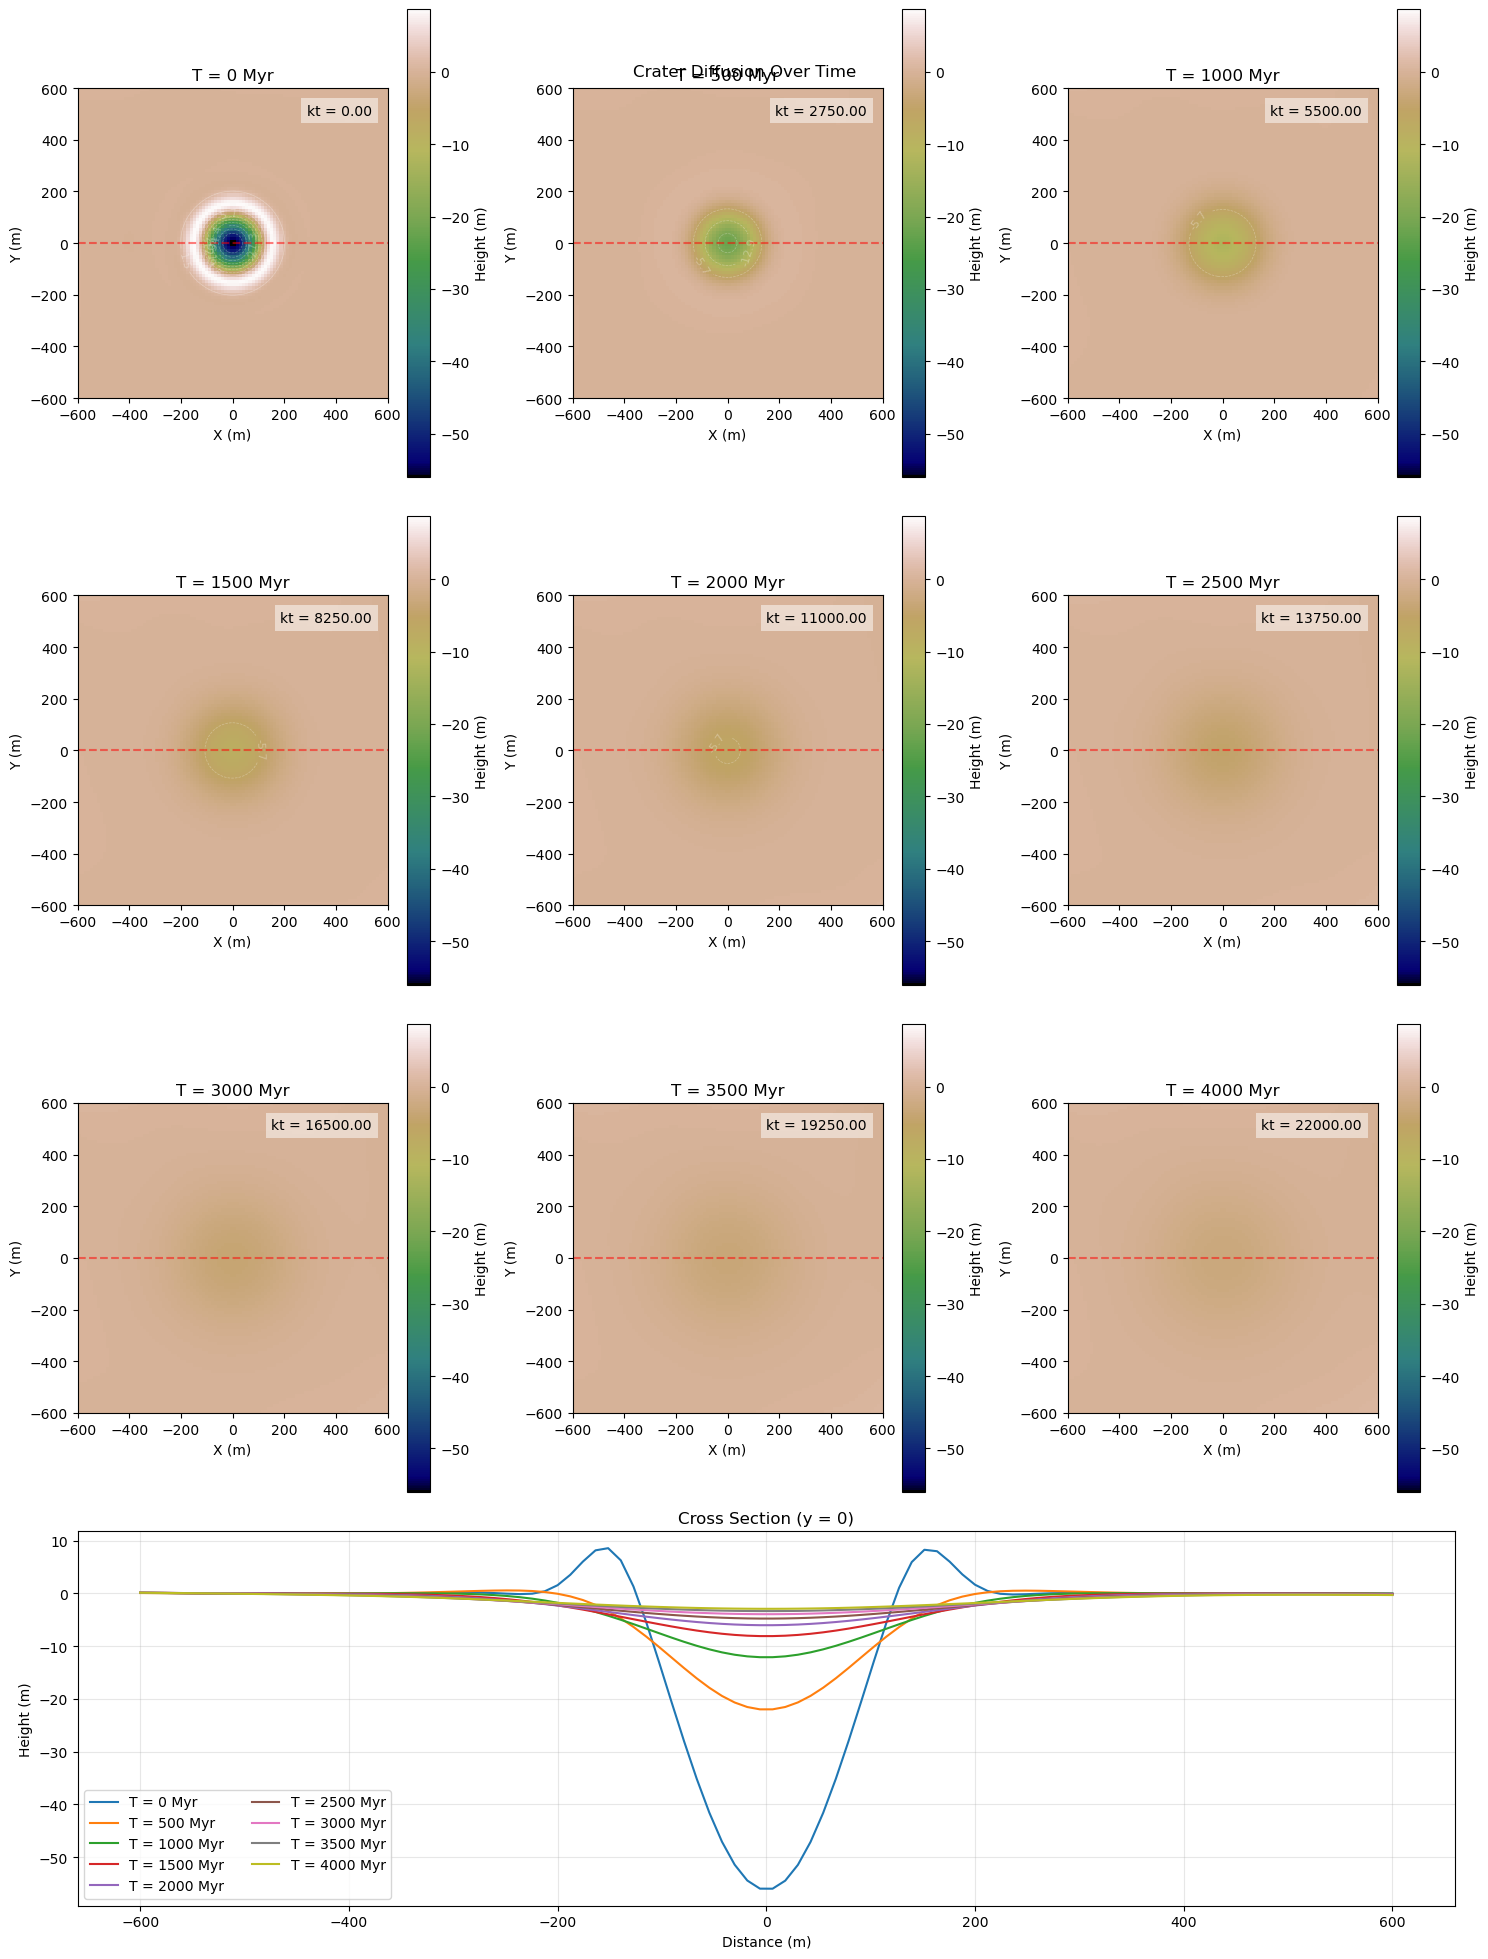

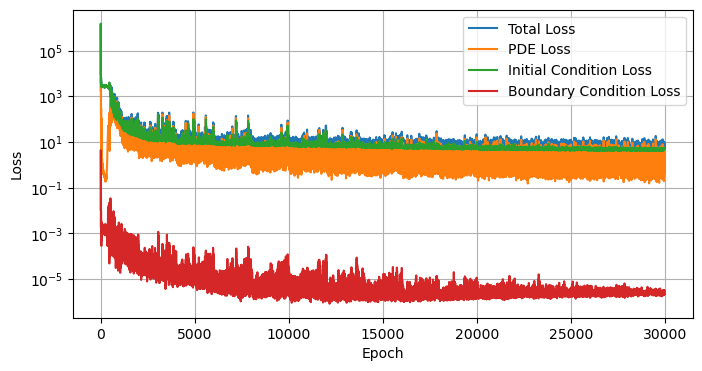

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from crater_diffusion_pinn import CraterDiffusionPINN
from crater_diffusion_utils import plot_crater_times

# Parameters
kappa = 5.5  # diffusion coefficient (m²/Myr)
D = 100 * np.pi / 2 #np.sqrt(kappa)  # crater diameter (m), sqrt kappa makes the time scaling 1:1 at 1 million years.
radius = D / 2.0
r_max = tf.cast(2.0 * D, dtype=tf.float32)  # half grid extent in meters
t_max = np.ceil(D**2 / kappa) # appx 4.5 Gyr

# Create and train the PINN
pinn = CraterDiffusionPINN(kappa, radius, r_max, t_max)
pinn.model = pinn._build_network()
# pinn.model.load_weights("pinn_pure_10000_epoch_varD.keras")
losses = pinn.train(n_epochs=50000, n_points = 1000)

# Predict at different times
times = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
# times = [t_max * ts / (0.5 * times[-1])  for ts in times]
predictions = []

# Parameters for visualization
kappa = 5.5  # diffusion coefficient (m²/Myr)
D = 300
radius = D / 2.0
r_max = tf.cast(2.0 * D, dtype=tf.float32)  # half grid extent in meters
t_max = 4500

# Create prediction grid
x = np.linspace(-r_max, r_max, 100)  # Grid in meters
y = np.linspace(-r_max, r_max, 100)  # Grid in meters
X, Y = np.meshgrid(x, y)

pinn.__init__(kappa, radius, r_max, t_max)

for t in times:
    h_pred = pinn.predict(X.flatten(), Y.flatten(), t * np.ones_like(X.flatten()))
    predictions.append(D * h_pred.reshape(X.shape))

fig = plot_crater_times(predictions, x, y, kappa, times, "Crater Diffusion Over Time")
fig.show()

# Plot loss history
plt.figure(figsize=(8, 4))
plt.semilogy(losses[:, 0], label='Total Loss')
plt.semilogy(losses[:, 1], label='PDE Loss')
plt.semilogy(losses[:, 2], label='Initial Condition Loss')
plt.semilogy(losses[:, 3], label='Boundary Condition Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## save and load networks

In [2]:
# pinn.model.save("pinn_pure_29951_epoch_varD_depth4.keras")
# pinn.model.load_weights("pinn_pure_29951_epoch_varD_depth4.keras")
# pinn.visualize_collocation_points()

# additional plots at different diameters

/var/folders/fz/2g6_hdjd4yndg54gmwq1402c0000gn/T/ipykernel_26551/4057197550.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


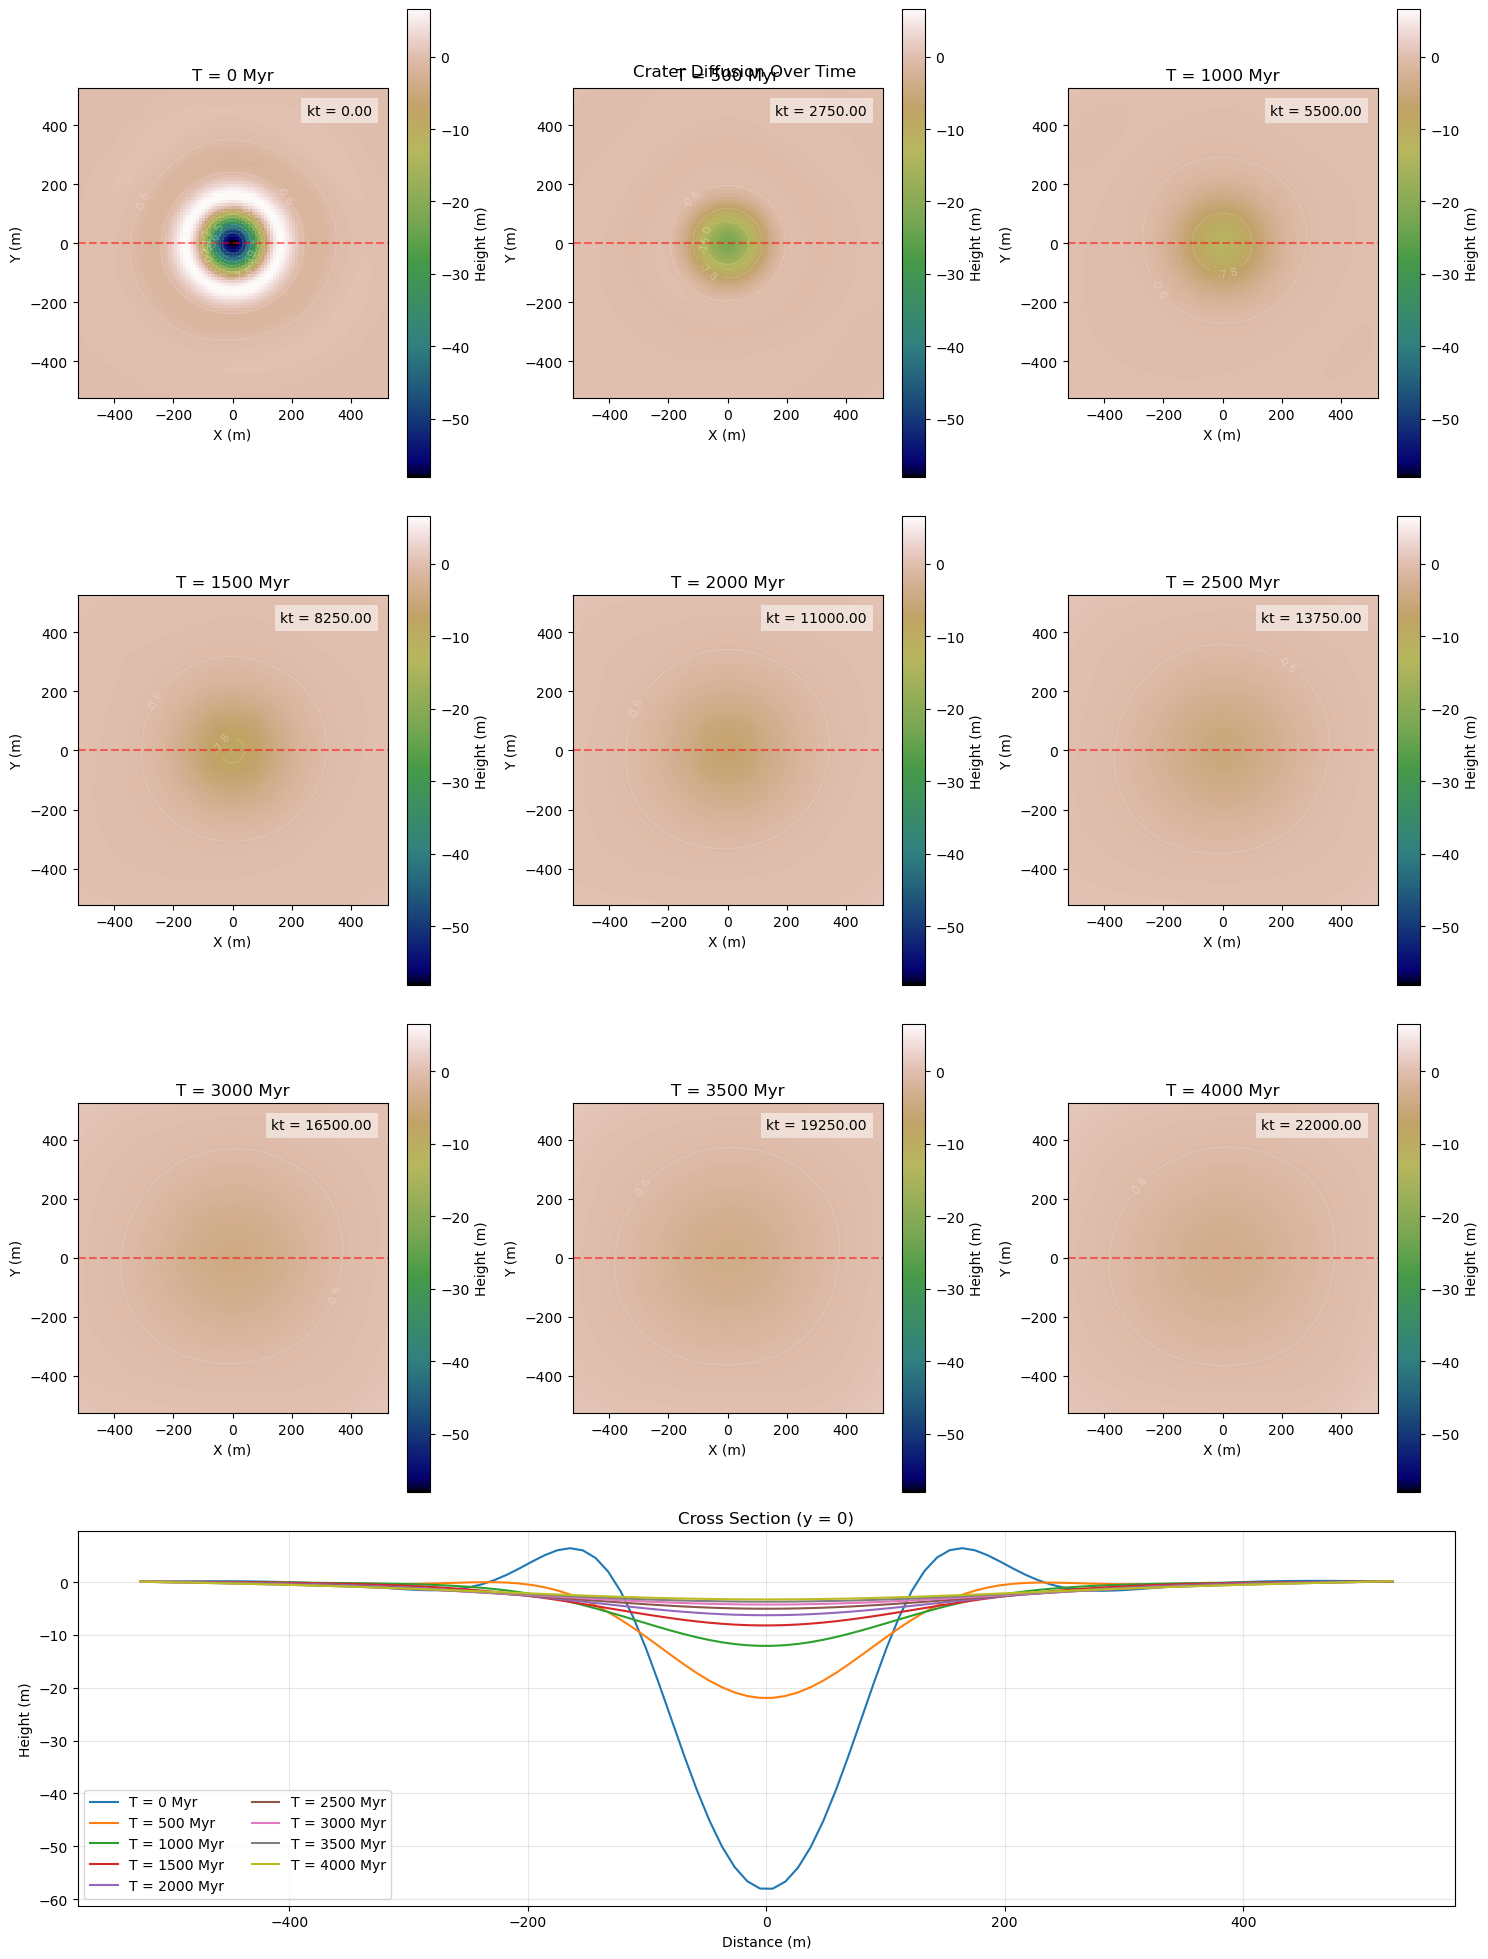

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from crater_diffusion_utils import h_of_r_fasset2014, plot_crater_times


# Parameters
D = 300 #100 * np.pi / 2  # crater diameter (m)
radius = D / 2
r_max = 1.75*D
kappa = 5.5  # diffusion coefficient (m²/Myr)
t_max = 4500 #4 #np.min((np.ceil(radius**2 / kappa), 4500)) #3000  # Total time in million years
time_scale = (radius**2) / kappa

# Create prediction grid
x = np.linspace(-r_max, r_max, 100)  # Grid in meters
y = np.linspace(-r_max, r_max, 100)  # Grid in meters
X, Y = np.meshgrid(x, y)

pinn.__init__(kappa, radius, r_max, t_max)
# pinn.model.layers[1].time_scale = ((radius)**2) / kappa

# Predict at different times
times = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
if time_scale < 4000:
    ts = time_scale / 4000
    times = [ts*t for t in times]
# times = [t*2 for t in times]
# times = [time_scale * ts / (0.8*times[-1])  for ts in times]
predictions = []

for t in times:
    h_pred = pinn.predict(X.flatten(), Y.flatten(), t * np.ones_like(X.flatten()))
    predictions.append(D * h_pred.reshape(X.shape))

fig = plot_crater_times(predictions, x, y, kappa, times, "Crater Diffusion Over Time")
fig.show()

## Compare to Fasset and Thomson plots

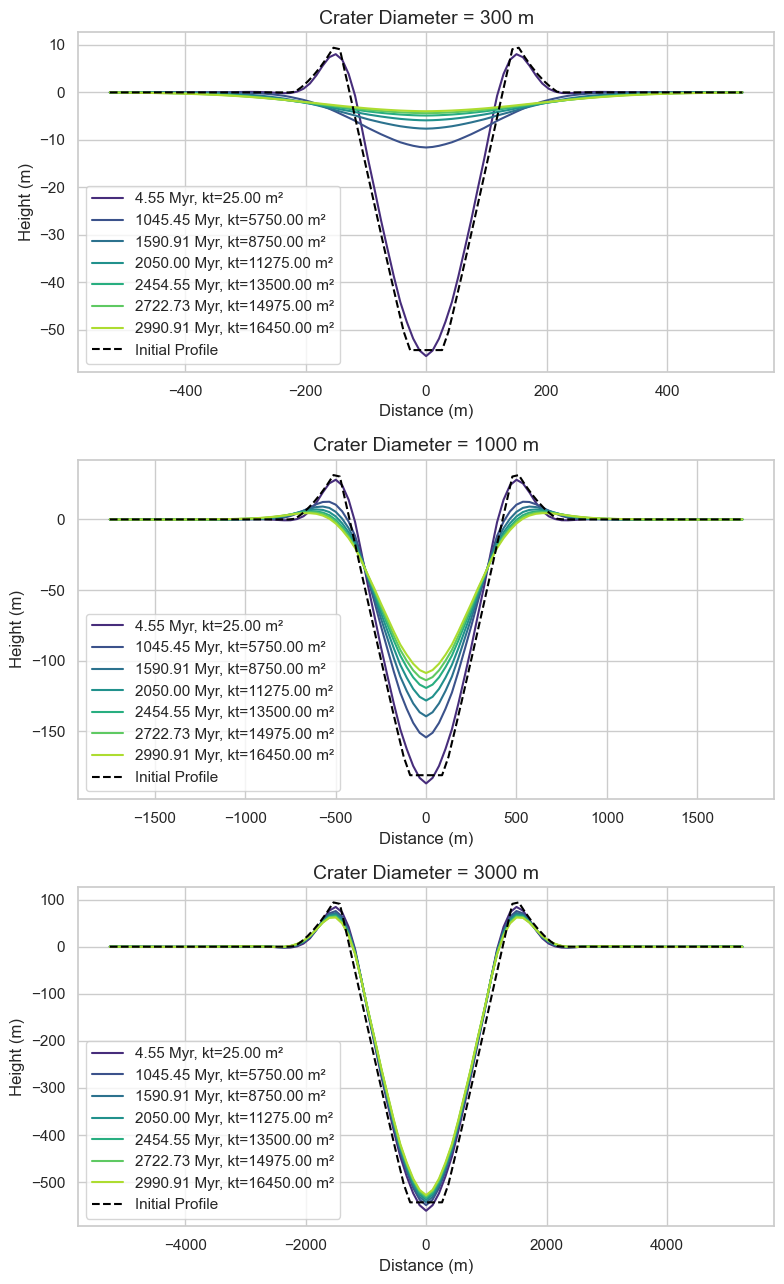

In [10]:
import seaborn as sns

# Set the style for seaborn
sns.set_theme(style="whitegrid")

# recreate plot from fasset and thomson 2014 using our NN

# Parameters for different crater diameters
D_list = [300, 1000, 3000]
kt_list = [25, 5750, 8750, 11275, 13500, 14975, 16450]
times = [kt / kappa for kt in kt_list]

# Create a color palette
colors = sns.color_palette("viridis", len(times))

fig, axs = plt.subplots(len(D_list), 1, figsize=(8, 13))

for i, D in enumerate(D_list):
    radius = D / 2
    r_max = 1.75 * D

    # Create prediction grid
    x = np.linspace(-r_max, r_max, 100)  # Grid in meters
    y = np.linspace(-r_max, r_max, 100)  # Grid in meters
    X, Y = np.meshgrid(x, y)

    r_values = np.linspace(-r_max, r_max, len(x))
    h_init = h_of_r_fasset2014(r_values, D)

    pinn.__init__(kappa, radius, r_max, t_max)

    predictions = []
    kt_values = []
    
    for t in times:
        h_pred = pinn.predict(X.flatten(), Y.flatten(), t * np.ones_like(X.flatten()))
        predictions.append(D * h_pred.reshape(X.shape))

    for j, t in enumerate(times):
        # axs[i].plot(x, predictions[j][len(x)//2, :], label=f"{t} Myr, kt={kt_values[j]:.2f} m²", color=colors[j])
        radial_distances = np.sqrt(X**2 + Y**2)
        radial_bins = np.linspace(0, r_max, len(x)//2)
        radial_profile = np.zeros_like(radial_bins)

        for k in range(len(radial_bins) - 1):
            mask = (radial_distances >= radial_bins[k]) & (radial_distances < radial_bins[k + 1])
            radial_profile[k] = np.mean(predictions[j][mask])

        full_radial_profile = np.concatenate((radial_profile[::-1], radial_profile[1:]))
        full_radial_bins = np.concatenate((-radial_bins[::-1], radial_bins[1:]))
        axs[i].plot(full_radial_bins, full_radial_profile, label=f"{t:.2f} Myr, kt={kt_list[j]:.2f} m²", color=colors[j])
        # axs[i].plot(-radial_bins, radial_profile, label=f"{t} Myr, kt={kt_values[j]:.2f} m²", color=colors[j])
        # axs[i].plot(radial_bins, radial_profile, color=colors[j])
    axs[i].plot(r_values, D * h_init, label="Initial Profile", color='black', linestyle='--')
    axs[i].set_title(f"Crater Diameter = {D} m", fontsize=14)
    axs[i].set_xlabel("Distance (m)", fontsize=12)
    axs[i].set_ylabel("Height (m)", fontsize=12)
    axs[i].legend()#loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)

plt.tight_layout()
plt.show()

## Model comparison to simulation results

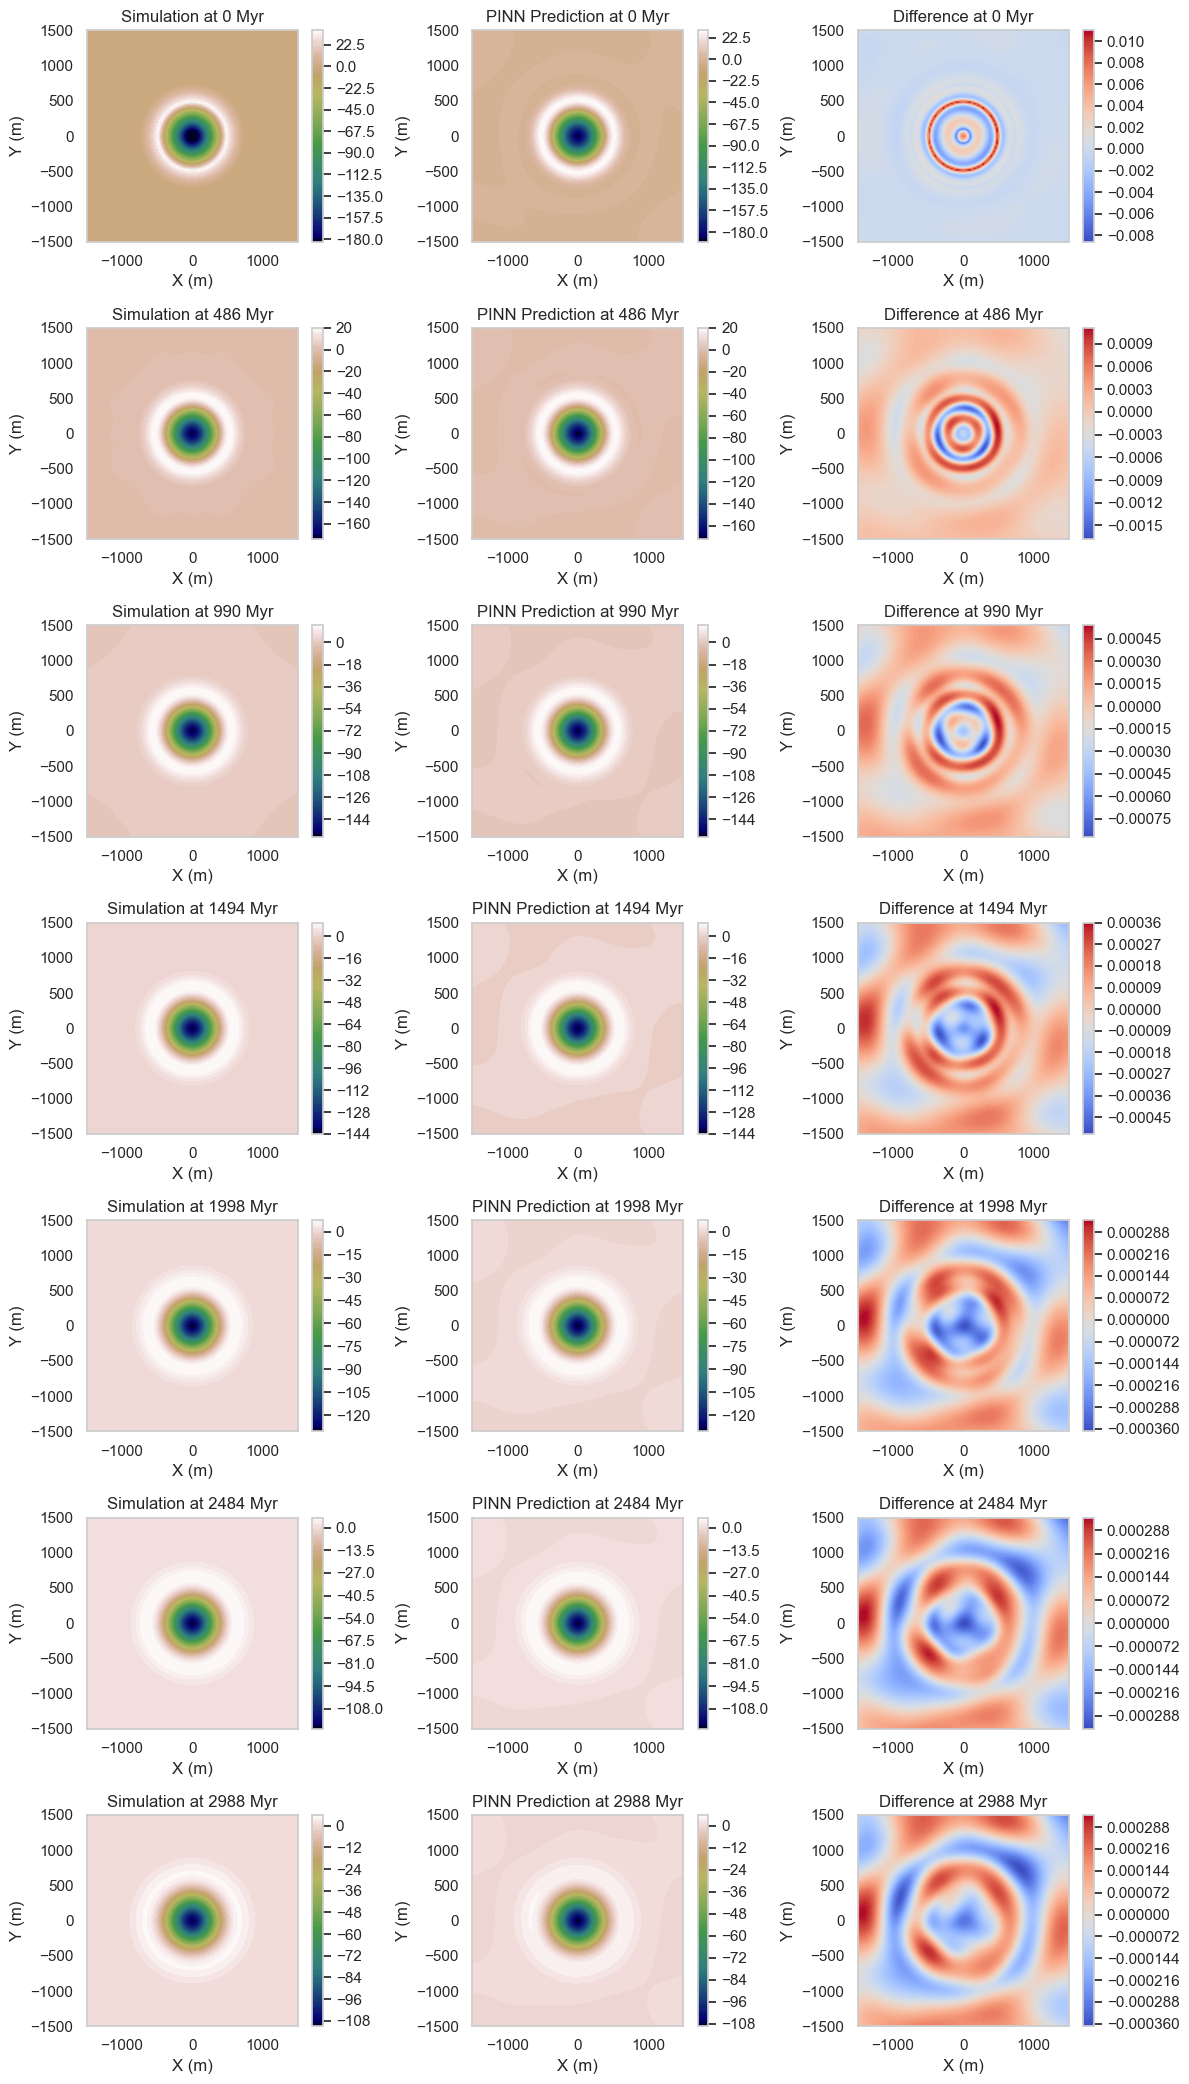

In [21]:
import numpy as np
from crater_diffusion_utils import plot_crater_times
from crater_diffusion_pinn import CraterDiffusionPINN

import matplotlib.pyplot as plt

# Load simulation results
D = 1000
r = D/2.0
kappa = 5.5
r_max = 1.5*D
t_max = 4500

# Load the trained PINN
pinn = CraterDiffusionPINN(kappa, r, r_max, t_max)
pinn.model = pinn._build_network()
pinn.model.load_weights("pinn_pure_29951_epoch_varD_depth4.keras")

# simulation_file = f'fasset2014_2D_htimes_3000m_163.npz'
simulation_file = f'fasset2014_2D_htimes_1000m_18.npz'
simulation_data = np.load(simulation_file)
h_time_sim = simulation_data['h_time']
x_sim = simulation_data['x']
y_sim = simulation_data['y']
dt_sim = simulation_data['dt']

# Define the grid for the PINN
X, Y = np.meshgrid(x_sim, y_sim)

# Define times for comparison
target_comparison_times = [0, 500, 1000, 1500, 2000, 2500, 3000]

# Get indices for the comparison times
time_indices = [int(t / dt_sim) for t in target_comparison_times]

# Get simulation results at the comparison times
simulation_results = [h_time_sim[idx] for idx in time_indices]

comparison_times = [dt_sim * idx for idx in time_indices]

# Predict with PINN at the comparison times
pinn_predictions = []
for t in comparison_times:
    h_pred = pinn.predict(X.flatten(), Y.flatten(), t * np.ones_like(X.flatten()))
    pinn_predictions.append(D * h_pred.reshape(X.shape))

# Plot comparison
fig, axs = plt.subplots(len(comparison_times), 3, figsize=(12, 3 * len(comparison_times)))
for i, t in enumerate(comparison_times):
    # Plot simulation result
    ax_sim = axs[i, 0]
    cax_sim = ax_sim.contourf(x_sim, y_sim, simulation_results[i], levels=100, cmap='gist_earth')
    fig.colorbar(cax_sim, ax=ax_sim)
    ax_sim.set_title(f'Simulation at {t} Myr')
    ax_sim.set_xlabel('X (m)')
    ax_sim.set_ylabel('Y (m)')
    ax_sim.set_aspect('equal', 'box')

    # Plot PINN prediction
    ax_pinn = axs[i, 1]
    cax_pinn = ax_pinn.contourf(x_sim, y_sim, pinn_predictions[i], levels=100, cmap='gist_earth')
    fig.colorbar(cax_pinn, ax=ax_pinn)
    ax_pinn.set_title(f'PINN Prediction at {t} Myr')
    ax_pinn.set_xlabel('X (m)')
    ax_pinn.set_ylabel('Y (m)')
    ax_pinn.set_aspect('equal', 'box')

    # Plot difference
    ax_diff = axs[i, 2]
    diff = (simulation_results[i] - pinn_predictions[i]) / D
    cax_diff = ax_diff.contourf(x_sim, y_sim, diff, levels=100, cmap='coolwarm')
    fig.colorbar(cax_diff, ax=ax_diff)
    ax_diff.set_title(f'Difference at {t} Myr')
    ax_diff.set_xlabel('X (m)')
    ax_diff.set_ylabel('Y (m)')
    ax_diff.set_aspect('equal', 'box')

plt.tight_layout()
plt.show()

# Comparison Plots
<p align="center">
    <img src="files/fasset_thompson_2014_diffusion_profiles.jpg" width="45%">
    <img src="files/NN_Fasset_Thomson.png" alt="Our results" width="45%">
</p>

# Backpropagation and optimizers

Relationship between optimizer algorithms and backpropagation:

Backpropagation is the algorithm for computing gradients, while optimizers are the algorithms that use those gradients to update the model's parameters. Here's a more detailed breakdown:

1. Backpropagation (Gradient Computation)
- Calculates the gradient of the loss function with respect to each parameter (in our case x, y, and t)
- Determines how much each parameter contributed to the model's error
- Uses the chain rule to efficiently compute gradients through the network
- Essentially creates a sensitivity map showing how small changes in each weight would affect the overall loss

2. Optimizer Algorithms (Parameter Update)
- Take the gradients computed by backpropagation
- Decide how to actually modify the model's parameters to reduce the loss
- Different optimizers have different strategies for updating weights

Common Optimizer Strategies:
- SGD (Stochastic Gradient Descent): 
  ```
  new_weight = current_weight - learning_rate * gradient
  ```
  Simple, directly moves parameters opposite the gradient

- Adam (Adaptive Moment Estimation):
  - Maintains moving averages of both gradients and squared gradients
  - Adapts learning rates for each parameter
  - Combines benefits of RMSprop and momentum
  ```
  # Simplified conceptual algorithm
  m = beta1 * previous_momentum + (1-beta1) * gradient
  v = beta2 * previous_variance + (1-beta2) * (gradient)²
  new_weight = current_weight - learning_rate * m / (√v + ε)
  ```

- AdaGrad, RMSprop, etc., have their own unique parameter update rules

Analogy:
- Backpropagation is like a compass telling you the direction to improve
- Optimizers are like different modes of transportation deciding how to move in that direction
  - SGD is like walking in a straight line
  - Adam is like a smart GPS that adjusts speed and direction based on terrain

Visual Representation:
```
Loss Function
    ↓
    | (Gradient Computed via Backpropagation)
    ↓
Optimizer Algorithm
    ↓ (Applies Update Rule)
Updated Model Parameters
```

In TensorFlow/Keras, this looks like:
```python
# Backpropagation happens automatically when you call tape.gradient()
gradients = tape.gradient(loss, model.trainable_variables)

# Optimizer applies the updates
optimizer.apply_gradients(zip(gradients, model.trainable_variables))
```

The key is that backpropagation provides the "how much" (gradients), and optimizers provide the "how" (update strategy) for improving the model.
